# ch9. Random Forest

이전 챕터에서 decision tree 모델을 학습시켜 봤습니다. 그런데 이 때, 필연적으로 마주친 문제가 오버피팅 문제였습니다. 트리를 너무 깊게 만들면 오버피팅이 발생하고, 너무 얕게 만들면 모델의 정확도가 떨어집니다. 어떻게 하면 모델의 성능을 높이면서도, 오버피팅을 방지할 수 있을까요?

이러한 문제를 극복하고자 제안된 방식이 앙상블 방식입니다. 오버피팅을 방지하고, 모델의 성능을 높이기 위해서 여러 모델을 학습시키고, 이들의 평균 값 혹은 투표를 거쳐서 예측값을 내주는 방식입니다. 의사 결정 트리 계열의 알고리즘 중에서는 랜덤 포레스트가 앙상블의 대표적인 예시입니다.

## Random Forest

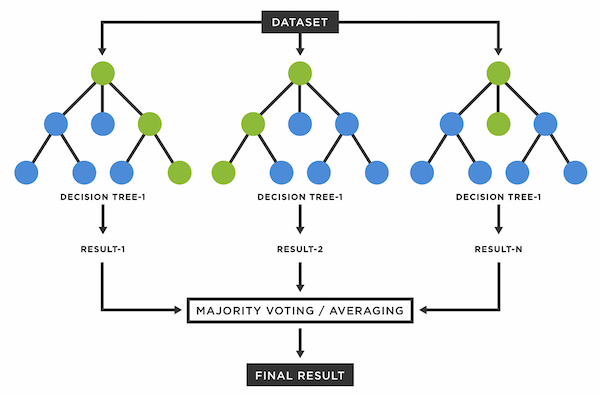

랜덤 포레스트는 feature를 무작위로 뽑거나, 데이터를 무작위로 뽑아서 여러 개의 작은 트리를 만들고 그 트리들을 결합합니다. 예를 들어 feature가 30개가 있다면 그 중에 랜덤하게 5개만 뽑아서 트리를 하나 만들고, 또 다시 랜덤하게 5개의 feature를 뽑아서 두번째 트리를 만들고, 이런 식으로 트리를 여러 개를 학습합니다.  그리고 각 트리별 예측값을 가지고 투표를 하여 최종 예측값을 리턴합니다.

### Random Forest 모델 학습시키기
랜덤 포레스트는 오버피팅에 강하고, 성능이 뛰어나서 실제로도 많이 사용되는 알고리즘입니다. 주요 하이퍼 파라미터는 아래와 같습니다.
- n_estimators: 트리의 개수
- max_features: 개별 트리 학습시 무작위로 선택하는 피쳐 수
- max_depth: 각 트리별 최대 깊이

그렇다면 간단히 모델을 만들어 보겠습니다.

In [1]:
import pandas as pd

train_df = pd.read_csv("./data/preprocessed_train.csv")
test_df = pd.read_csv("./data/preprocessed_test.csv")

In [2]:


x_train = train_df.drop(["PassengerId", "Survived"], axis=1)
y_train = train_df["Survived"]
x_test = test_df.drop(["PassengerId"], axis=1)

In [4]:
from sklearn.model_selection import cross_val_score, KFold

kf = KFold(n_splits=5, shuffle=True, random_state=1234)

In [6]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(
    n_estimators=10,   # decisiontree를 10개 만들겠다
    criterion="entropy",
    max_depth=5,
    random_state= 1234
)

In [7]:
scores = cross_val_score(model, x_train, y_train, cv=kf)

In [8]:
scores

array([0.84916201, 0.80898876, 0.8258427 , 0.74157303, 0.83707865])

In [9]:
scores.mean()

0.8125290314481199

In [10]:
# Random Forest => decision tree를 여러개 사용하니까 정확도가 더 높아지는 걸 알 수 있음

In [37]:
model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10,
                       random_state=1234)

### Random Forest 모델 시각화하기
이전 decision tree를 plot 했던 코드를 사용하여 random forest의 각 decision tree가 어떻게 학습되었는지 확인 할 수 있습니다.

In [38]:
# model.estimators_ 실행시켜보면 다 나옴
# 언더바 -> 어떤 형태의 변수다 구분지을 때, 보통 외부에서 가급저이면 접근안 했음 좋겠다 
# 랜덤포레스트 외에는 클래스 외부에서는 쓰지 말아줬음 좋겠다

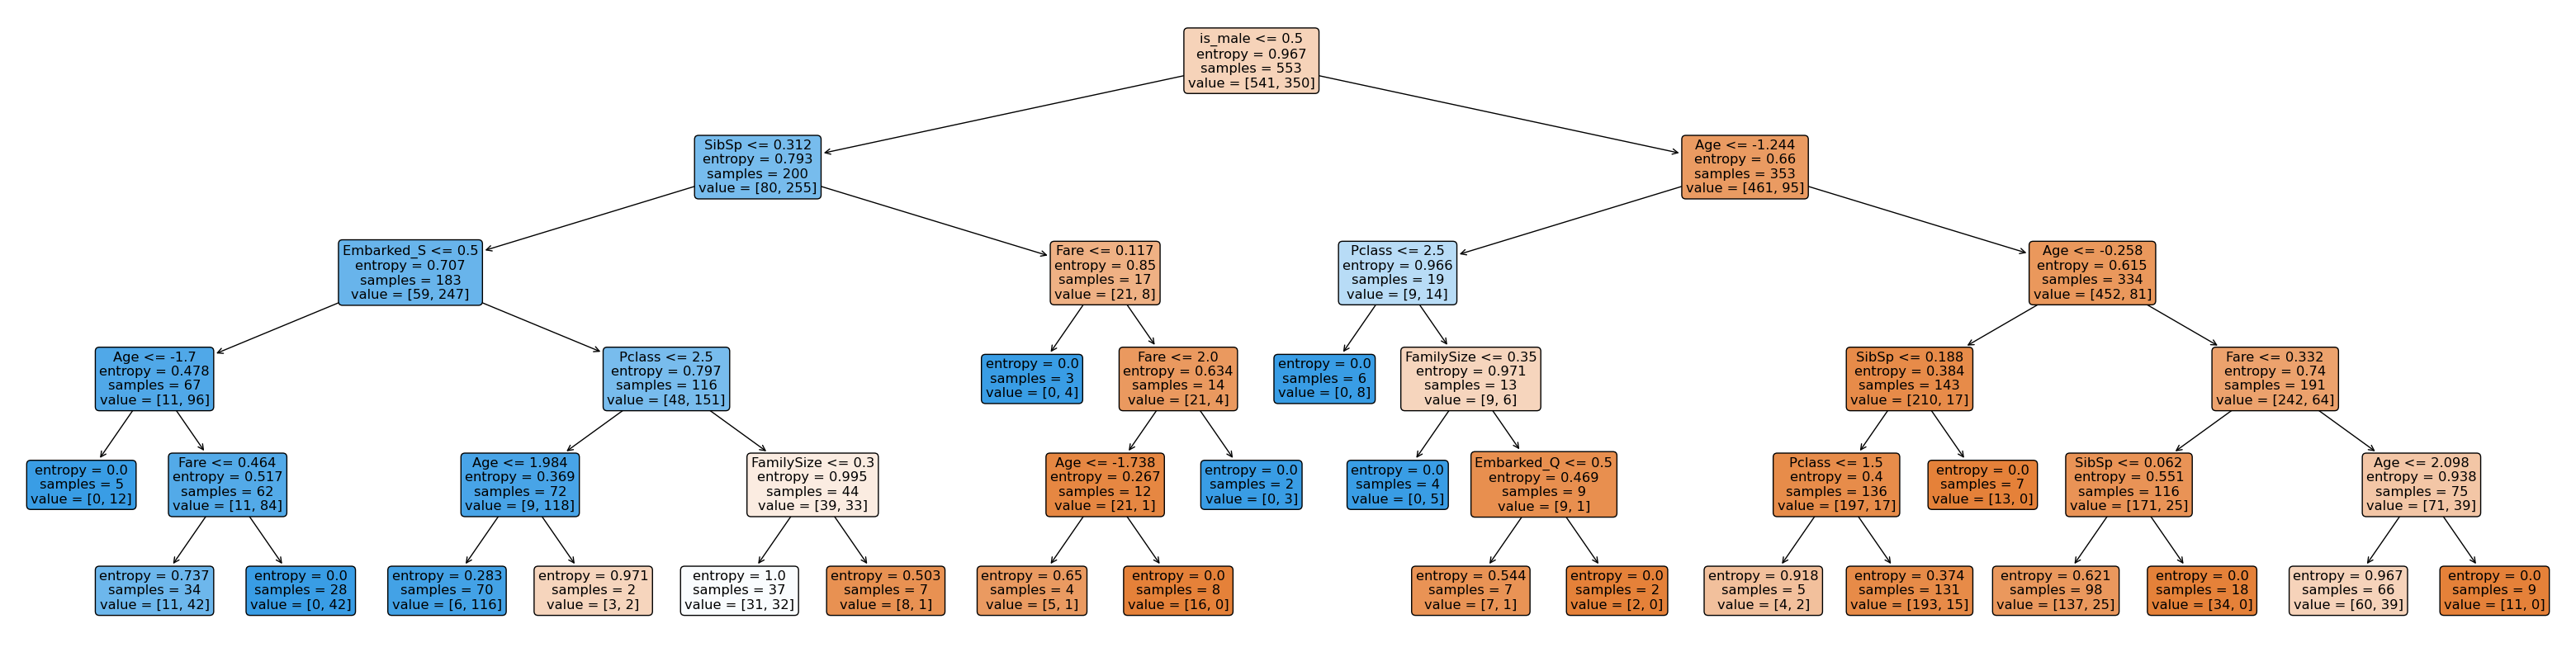

In [39]:
from sklearn.tree import plot_tree
from matplotlib import pyplot as plt

feature_names = x_train.columns.to_list()
plt.figure(figsize=(40,10))

_ = plot_tree(
    model.estimators_[1], 
    feature_names = feature_names,
    filled = True,  
    rounded = True
)

실제로 여러 트리가 서로 다른 형태로 학습되는 것을 확인할 수 있었습니다. 랜덤 포레스트는 이런 방식으로 예측력은 높이면서 오버피팅은 방지합니다.

### Stratified K-fold Validation

여기서 cross validation 기법을 한가지만 더 살펴보겠습니다. K-fold validation을 하면 trainset을 무작위로 K 등분하고, 그 중에 하나를 validation set으로 삼습니다. 이 경우, validation set 내부의 라벨 비율이 전체 데이터 셋과 차이가 날 수 있습니다. 이 비율을 동일하게 유지하면서 무작위로 K 등분 해주는 기법이 Stratified K-fold validation입니다. 사용법은 k-fold validation 과 거의 비슷합니다.

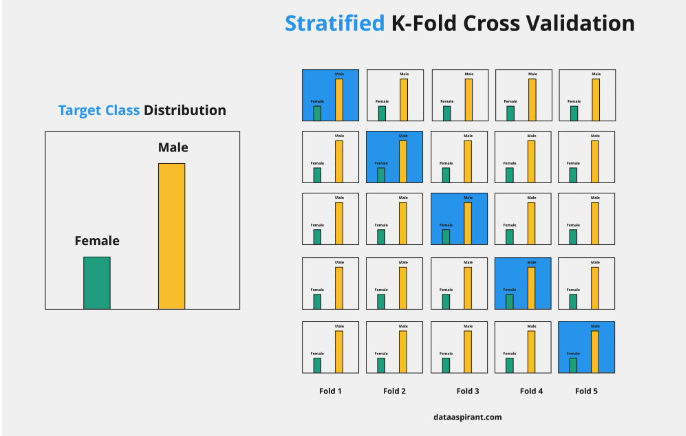

In [40]:
from sklearn.model_selection import StratifiedKFold

stratified_kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=1234)

## Hyper Parameter Optimization
random forest 모델의 형태를 결정하는 주요 요소들이 있었고, 이를 하이퍼 파라미터라고 불렀습니다. 그런데 이렇게 중요한 하이퍼 파라미터를 감에 의존하여 결정했었습니다. 이번에는 grid search라는 Hyper Paramter Optimization 기법과 함께 사용해보겠습니다.

grid search는 말 그대로 모든 조합으로 모델을 학습시켜보고, 가장 성능이 좋은 조합을 찾는 기법입니다. 역시나 편하게 구현체를 이용할 수 있습니다.

In [41]:
from sklearn.model_selection import GridSearchCV

In [47]:
param_grid = {
    "n_estimators": [10, 30, 50],
    "max_depth": [3,5,10]
}

In [48]:
grid_search = GridSearchCV(
    estimator= model,
    param_grid= param_grid,
    cv= stratified_kf
)

In [49]:
grid_search.fit(x_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=1234, shuffle=True),
             estimator=RandomForestClassifier(criterion='entropy', max_depth=5,
                                              n_estimators=10,
                                              random_state=1234),
             param_grid={'max_depth': [3, 5, 10], 'n_estimators': [10, 30, 50]})

In [50]:
grid_search.best_params_

{'max_depth': 10, 'n_estimators': 30}

In [51]:
grid_search.best_score_

0.8293892411022534

## Random Forest 모델 kaggle에 제출하기
Grid Search를 통해서 best parameter를 찾았으니, 이제 random forest 모델을 전체 train 셋에 대해서 학습시켜 본 뒤, kaggle에 제출해보겠습니다.

In [66]:
# grid_search.best_params_ 넣어서 새로운 랜덤 포레스트 모델 만들기
# 파라미터 조금씩 바꿔보기기

model = RandomForestClassifier(
    n_estimators=30,  
    criterion="entropy",
    max_depth=10,
    random_state= 1234
)

In [67]:
model.fit(x_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=5, n_estimators=10,
                       random_state=1234)

In [68]:
y_test_pred = model.predict(x_test)

In [69]:
test_df["Survived"] = y_test_pred

In [70]:
test_df[["PassengerId", "Survived"]]

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


In [71]:
test_df[["PassengerId", "Survived"]].to_csv("./data/submission_rf.csv", index=False)

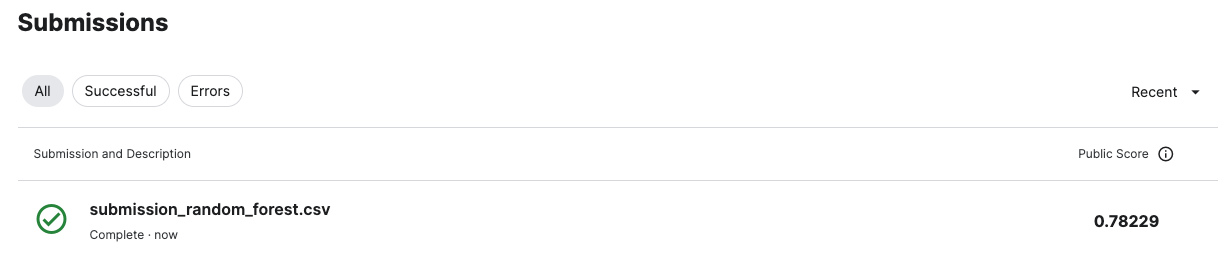

https://www.kaggle.com/competitions/titanic/submissions